# Experiment 5 - Quantifying chromatograpy performance w/ a commercial standard

## Overview

The goal of the experiment wass threefold, but this notebook contains data only on the third goal:

3. Try a few method variations using Supelco's / Sigma's [Reverse Phase Gradient Test Mix](http://www.sigmaaldrich.com/catalog/product/supelco/48271?lang=en&region=US) to calculate chromatographic parameters of interest.

## Samples

Sample 13 was the Gradient Test Mix used as supplied.

In [1]:
require(ggplot2)  # for pretty multivariate plotting
require(xcms, quietly=T)  # the main package for metabolomics data analysis
require(xlsx, quietly=T)  # for reading xlsx files
require(stringr)  # for easy consistent handling of strings and regular expressions in R
require(repr)  # for resizing plots in the Jupyter notebook
require(plyr)  # for use of the . function
require(viridis)  # for a nice colormap
require(dplyr)  # packages by Hadley Wickham should more or less be required in every R program
require(tidyr)  # ditto
require(zoo)

# use code I wrote to analyze experiment 1
source('../exp_001/code/experiment_01_helper_functions.r')

Loading required package: ggplot2
Warning message:
In fun(libname, pkgname): mzR has been built against a different Rcpp version (0.12.1)
than is installed on your system (0.12.3). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.
Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, g

In [2]:
# read the data (from the first sheet in the indicated file)
my_dat <- read.xlsx('experiment_005_design.xlsx', 1)

# manually select only rows and columns of interest
sample_contents <- my_dat[1:13, 1:7]

# show the result
sample_contents %>% filter(sample==13)

# save the result
save(sample_contents, file='saved_data/sample_contents.rdat')

,sample,colins_label,strain,strain_genotype,cluster_name_1,cluster_name_2,strain_description
1,13,NA,NA,Supelco 48271,Reverse Phase Gradient Mix,NA,http://www.sigmaaldrich.com/catalog/product/supelco/48271?lang=en®ion=US


## Instrument methods

### For sample 13

For sample 13 I tried three total variants to the standard Sattely lab protocol:

* The standard ~55 minute method aka **`long`**
* The ~20 minute "blank" method aka **`short`**
* A new ~10 minute aka **`shorter`**



In [3]:
# read the data (from the 2nd sheet in the indicated file)
my_dat <- read.xlsx('experiment_005_design.xlsx', 2)

# manually select only rows and columns of interest
worklist <- my_dat[1:16, 1:6]

# show the result
worklist %>% filter(Sample.Name == 13)

,Sample.Name,Sample.Position,Method,Data.File,Inj.Vol..uL.,Injection.Order
1,13,P1B4,long,13,5,14
2,13,P1B4,short,13_short,5,15
3,13,P1B4,shorter,13_shorter,5,16


## Data analysis

Proteowizard's `msconvert` was used to make `*.mzML` files from the `*.d` files.

# The standards mix

The goal here was to quantitatively compare two methods for chromatographic performance.  Many of these are functions of peak width.  Peak width can be measured in many ways.  The easiest way to measure is FWHM, i.e. full width at half maximum.  The most "fundamental" measure (for Gaussian peaks) is standard deviation, $\sigma$.  Many sources give the peak width $W$ as equal to $4 \sigma$, which is the width at 13.4 % of the peak height.  Thus:

$$ W = 4 \sigma = 1.7 \mathrm{\;FWHM}$$

Important measures of performance:

* [Resolution](http://www.shimadzu.com/an/hplc/support/lib/lctalk/resol-1.html): $R=\frac{t_2 - t_1}{{1 \over 2} \left( 4 \sigma_1 + 4 \sigma_2 \right )} = 1.18 \frac{t_2 - t_1}{ \left( FWHM_1 + FWHM_2 \right )}$

* [Peak capacity](http://www.dionex.com/en-us/webdocs/70908-PO-Optimization-Peak-Capacity-19Mar2010-LPN2490-01.pdf): $n_c = \frac{t_G}{W_{avg}} + 1 = \frac{t_G}{1.7 \mathrm{\;FWHM}_{avg}} + 1$


In [4]:
# xraw_long <- xcmsRaw(file='mzml_files/13.mzML')
# xraw_short <- xcmsRaw(file='mzml_files/13_shorter.mzML')
# xraw_shorter <- xcmsRaw(file='mzml_files/13_shortest.mzML')

# save(xraw_long, xraw_short, xraw_shorter, file='saved_data/hplc_rp_stds_mix_xraws.rdat')

In [5]:
load('saved_data/hplc_rp_stds_mix_xraws.rdat')

In [6]:
# data on molecules in the RP mix from the python notebook

my_mzs <- c(113.03511859,  195.10254593,  167.07110577,   95.04961667,
            237.14970716, 153.05538569,  181.08682585)

my_compounds <- c('uracil', 
                'butyl 4-hydroxybenzoate', 
                'ethyl 4-hydroxybenzoate',
                'phenol',
                'heptyl paraben',
                'methyl 4-hydroxybenzoate',
                'propyl 4-hydroxybenzoate'
                 )

rp_cpds <- data.frame(compound = my_compounds, mz = my_mzs)

rp_cpds %>% arrange(mz)

,compound,mz
1,phenol,95.04962
2,uracil,113.0351
3,methyl 4-hydroxybenzoate,153.0554
4,ethyl 4-hydroxybenzoate,167.0711
5,propyl 4-hydroxybenzoate,181.0868
6,butyl 4-hydroxybenzoate,195.1025
7,heptyl paraben,237.1497


In [7]:
# get ready to extract mz windows and the rt window of interest

ppm <- 5

min_mzs <- rp_cpds$mz * (1 - ppm/1e6)
max_mzs <- rp_cpds$mz * (1 + ppm/1e6)

mz_matrix <- matrix(c(min_mzs, max_mzs), ncol=2)
rt_matrix <- mz_matrix
rt_matrix[, 1] <- 0
rt_matrix[, 2] <- 3000

In [8]:
# load the EIC generating function 
source('code/getEICdf.r')

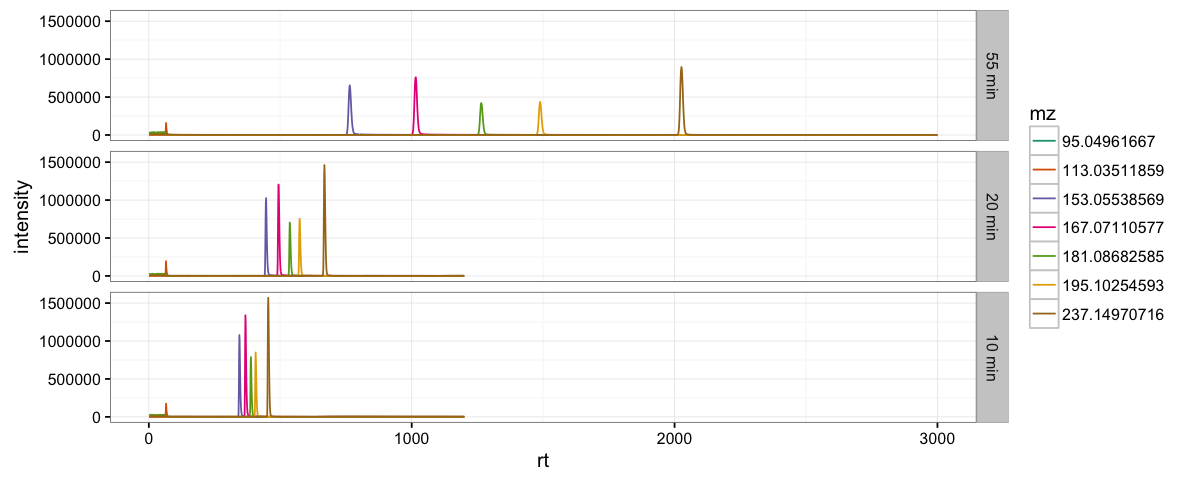

In [9]:
options(repr.plot.width=10, repr.plot.height=4)

xeic_long <- getEICdf(xraw_long, mzrange=mz_matrix, rtrange=rt_matrix)
xeic_short <- getEICdf(xraw_short, mzrange=mz_matrix, rtrange=rt_matrix)
xeic_shorter <- getEICdf(xraw_shorter, mzrange=mz_matrix, rtrange=rt_matrix)

xeics <- rbind(xeic_long, xeic_short, xeic_shorter)
levels(xeics$sample) <- c('55 min', '20 min', '10 min')

ggplot(data=xeics, aes(x=rt, y=intensity, color=mz)) + 
    facet_grid(sample~.) + 
    geom_line() +
    theme_bw() +
    scale_color_brewer(palette = 'Dark2')


In [10]:
# find peak apexes
rp_cpds$mz <- as.factor(rp_cpds$mz)

rt_max <- xeics %>% 
          full_join(rp_cpds, by='mz') %>%
          group_by(sample, mz) %>% 
          filter(intensity==max(intensity) & intensity>0) %>% 
          arrange(mz) %>%
          select(sample, mz, peak_rt=rt, peak_intensity=intensity) %>%
          mutate(peak_rt=peak_rt/60) %>%
          filter(row_number() == 1) 

levels(rt_max$sample) <- c('55 min', '20 min', '10 min')


rt_max

,sample,mz,peak_rt,peak_intensity
1,55 min,113.03511859,1.091283,158047.8
2,55 min,153.05538569,12.73273,654498.5
3,55 min,167.07110577,16.92962,760270.2
4,55 min,181.08682585,21.07663,419963.3
5,55 min,195.10254593,24.8072,436029.1
6,55 min,237.14970716,33.7673,895687.2
7,20 min,113.03511859,1.088217,193692
8,20 min,153.05538569,7.433517,1025087
9,20 min,167.07110577,8.216267,1204577
10,20 min,181.08682585,8.932483,704205.6


In [11]:
rt_width <- xeics %>% 
        full_join(rp_cpds, by='mz') %>%
        full_join(rt_max, by=c('sample', 'mz')) %>%
        mutate(rt=rt/60, relative_rt = rt-peak_rt) %>%
        group_by(mz, sample) %>% 

        # do a rolling average and normalize the intensity by each peak after normalization
        mutate(norm_int = abs(rollmean(intensity, align='center', k=5, fill = NA)/peak_intensity)) %>%
          
        # get the points in the data that are just above (closest to) the FWHM
        filter(norm_int >= 0.5) %>%
        summarize(compound=unique(compound), 
                  peak_rt = unique(peak_rt),
                  
                  rt_hm_late = max(rt), 
                  rt_hm_early = min(rt), 
                  front_int = min(norm_int[rt==rt_hm_early]),
                  back_int = max(norm_int[rt==rt_hm_late])) %>%
        mutate(fwhm = rt_hm_late - rt_hm_early) %>%
        filter(compound != 'uracil') %>%
        arrange(mz)
    
rt_width

names(rt_width)

,mz,sample,compound,peak_rt,rt_hm_late,rt_hm_early,front_int,back_int,fwhm
1,153.05538569,55 min,methyl 4-hydroxybenzoate,12.73273,12.83265,12.66612,0.6105343,0.5396512,0.1665333
2,153.05538569,20 min,methyl 4-hydroxybenzoate,7.433517,7.483467,7.4002,0.6195804,0.5109851,0.08326667
3,153.05538569,10 min,methyl 4-hydroxybenzoate,5.73995,5.789917,5.7233,0.6160385,0.5320289,0.06661667
4,167.07110577,55 min,ethyl 4-hydroxybenzoate,16.92962,17.01288,16.82968,0.5209031,0.547282,0.1832
5,167.07110577,20 min,ethyl 4-hydroxybenzoate,8.216267,8.266217,8.1996,0.6573711,0.64947,0.06661667
6,167.07110577,10 min,ethyl 4-hydroxybenzoate,6.123,6.172967,6.10635,0.5942472,0.5302125,0.06661667
7,181.08682585,55 min,propyl 4-hydroxybenzoate,21.07663,21.17655,20.99335,0.5377511,0.5394355,0.1832
8,181.08682585,20 min,propyl 4-hydroxybenzoate,8.932483,8.98245,8.915833,0.6547506,0.6366023,0.06661667
9,181.08682585,10 min,propyl 4-hydroxybenzoate,6.472733,6.50605,6.439433,0.5043794,0.6263366,0.06661667
10,195.10254593,55 min,butyl 4-hydroxybenzoate,24.8072,24.90712,24.72392,0.5678418,0.5270189,0.1832


[1] "mz"          "sample"      "compound"    "peak_rt"     "rt_hm_late" 
[6] "rt_hm_early" "front_int"   "back_int"    "fwhm"

In [12]:
all_peaks <- rt_width %>% 
                rename(retention = peak_rt) %>% 
                ungroup() %>%
                select(compound, mz, sample, retention, fwhm)

all_peaks

,compound,mz,sample,retention,fwhm
1,methyl 4-hydroxybenzoate,153.05538569,55 min,12.73273,0.1665333
2,methyl 4-hydroxybenzoate,153.05538569,20 min,7.433517,0.08326667
3,methyl 4-hydroxybenzoate,153.05538569,10 min,5.73995,0.06661667
4,ethyl 4-hydroxybenzoate,167.07110577,55 min,16.92962,0.1832
5,ethyl 4-hydroxybenzoate,167.07110577,20 min,8.216267,0.06661667
6,ethyl 4-hydroxybenzoate,167.07110577,10 min,6.123,0.06661667
7,propyl 4-hydroxybenzoate,181.08682585,55 min,21.07663,0.1832
8,propyl 4-hydroxybenzoate,181.08682585,20 min,8.932483,0.06661667
9,propyl 4-hydroxybenzoate,181.08682585,10 min,6.472733,0.06661667
10,butyl 4-hydroxybenzoate,195.10254593,55 min,24.8072,0.1832


,sample,compound.x,compound.y,resolution
1,55 min,methyl 4-hydroxybenzoate,ethyl 4-hydroxybenzoate,14.16028
2,55 min,methyl 4-hydroxybenzoate,propyl 4-hydroxybenzoate,28.15231
3,55 min,methyl 4-hydroxybenzoate,butyl 4-hydroxybenzoate,40.73924
4,55 min,methyl 4-hydroxybenzoate,heptyl paraben,70.97399
5,20 min,methyl 4-hydroxybenzoate,ethyl 4-hydroxybenzoate,6.162426
6,20 min,methyl 4-hydroxybenzoate,propyl 4-hydroxybenzoate,11.80105
7,20 min,methyl 4-hydroxybenzoate,butyl 4-hydroxybenzoate,15.10546
8,20 min,methyl 4-hydroxybenzoate,heptyl paraben,26.19546
9,10 min,methyl 4-hydroxybenzoate,ethyl 4-hydroxybenzoate,3.392537
10,10 min,methyl 4-hydroxybenzoate,propyl 4-hydroxybenzoate,6.49


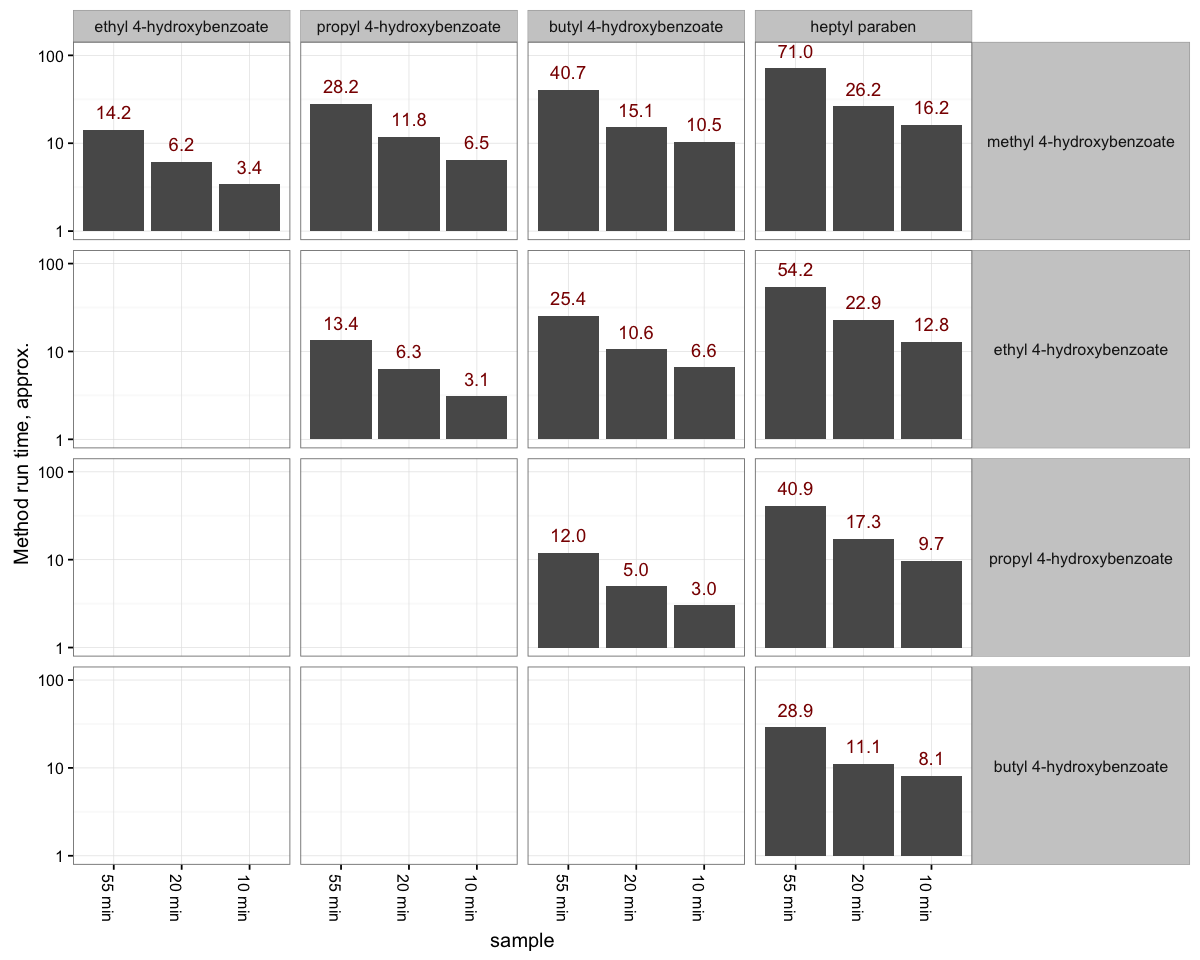

In [13]:
peak_comparison <- all_peaks %>% 
                    full_join(all_peaks, by='sample') %>%
                    filter(as.numeric(mz.x) < as.numeric(mz.y)) %>%
                    mutate(compound.x = factor(compound.x, unique(compound.x)),
                           compound.y = factor(compound.y, unique(compound.y))) %>%
                    mutate(resolution = 1.18*abs(retention.x - retention.y) / ((fwhm.x + fwhm.y))) %>%
                    select(sample, compound.x, compound.y, resolution)

peak_comparison

options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=peak_comparison, aes(x=sample, y=resolution, label=sprintf('%.1f', resolution))) + 
    geom_bar(stat='identity') + 
    geom_text(color='dark red', nudge_y=0.2) + 
    facet_grid(compound.x~compound.y, drop=FALSE) +
    scale_y_log10() +
    theme_bw() +
    theme(axis.text.x = element_text(angle=-90), strip.text.y = element_text(angle=0)) +
    ylab("Method run time, approx.")

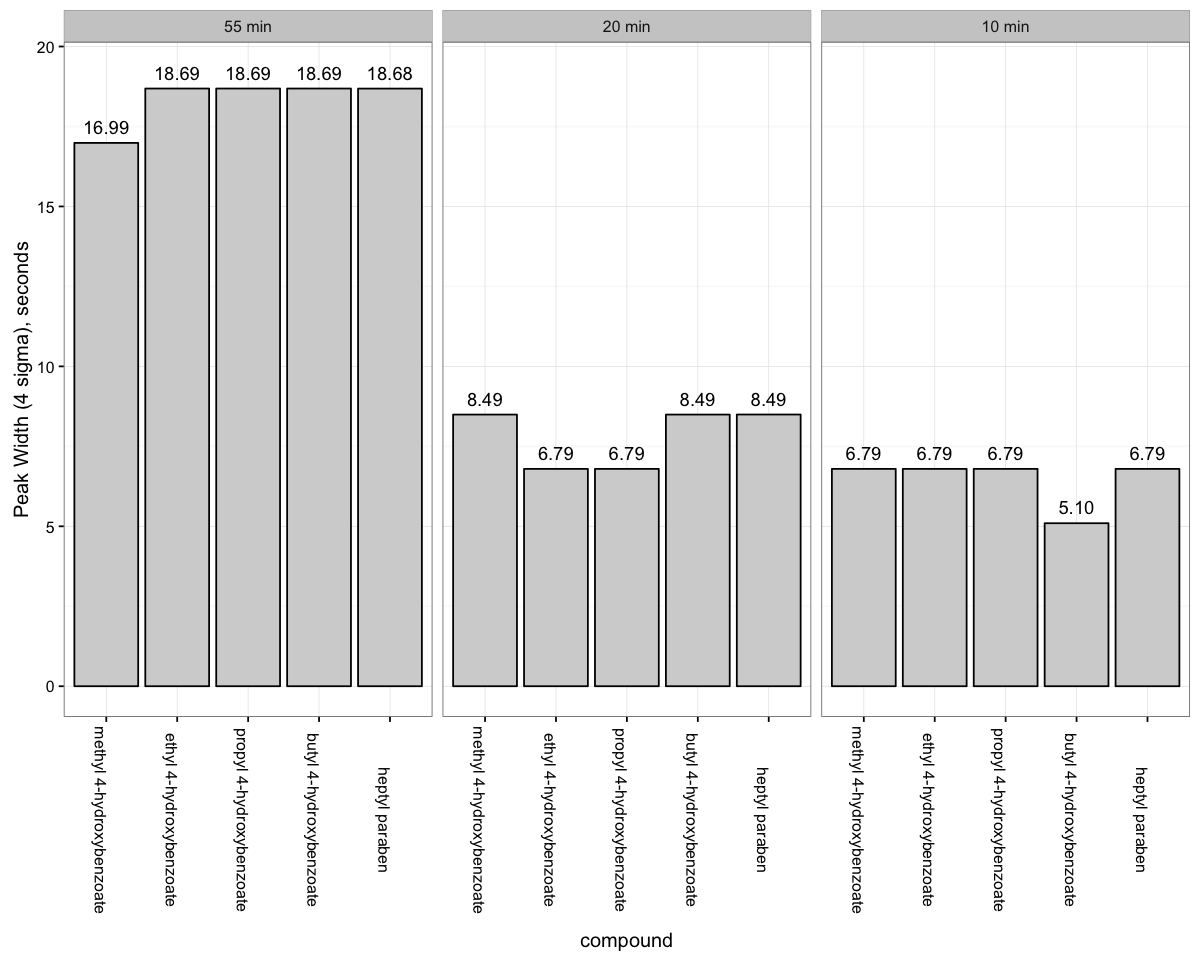

In [14]:
# peak width by peak
options(repr.plot.width=10, repr.plot.height=8)

all_peaks <- all_peaks %>% mutate(compound = factor(compound, unique(compound)))

ggplot(data=all_peaks, aes(x=compound, y=1.7*fwhm*60)) +
    geom_bar(stat='identity', color='black', fill='light gray') +
    facet_grid(.~sample) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle=-90)) +
    ylab('Peak Width (4 sigma), seconds') +
    geom_text(aes(label=sprintf('%.2f', 1.7*fwhm*60)), color='black', nudge_y = 0.5)

Peak width goes down strong in going to 20 minutes, but halving the gradient time to 10 minutes does not lower it much further.  This is a sign that peak capacity in the 10 minute run will be much reduced!

,sample,mean_fwhm,peak_capacity
1,55,0.1798633,180.8751
2,20,0.07661,154.5662
3,10,0.06328667,93.94774


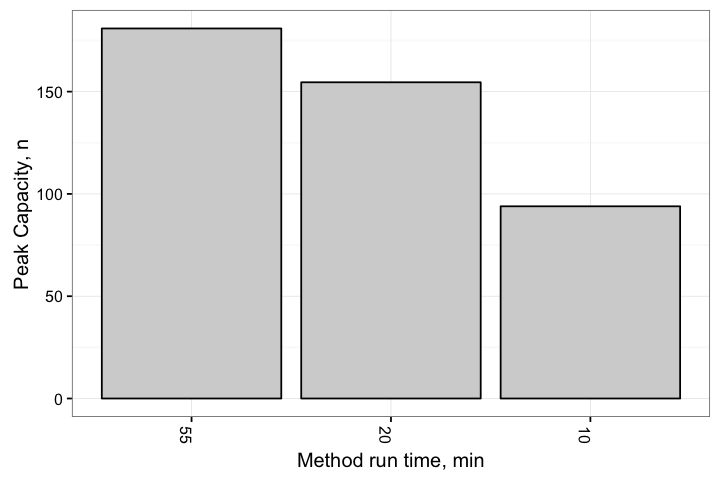

In [15]:
# peak capacity of a method
options(repr.plot.width=6, repr.plot.height=4)
avg_peaks <- all_peaks %>% 
                group_by(sample) %>%
                summarize(mean_fwhm=mean(fwhm))

levels(avg_peaks$sample) <- c(55, 20, 10)

avg_peaks$peak_capacity <- (as.numeric(as.character(avg_peaks$sample)) / (1.7*avg_peaks$mean_fwhm) + 1) 

avg_peaks
ggplot(data=avg_peaks, aes(x=sample, y=peak_capacity)) +
    geom_bar(stat='identity', fill='light gray', color='black') +
    theme_bw() +
    theme(axis.text.x = element_text(angle=-90)) +
    ylab('Peak Capacity, n') + 
    xlab('Method run time, min')


In conclusion, the peak capacity doesn't go down much in moving to a 20 minute method.  We should use it going forward for all samples.  A [2016 paper in _Anal. Chem._](http://www.ncbi.nlm.nih.gov/pubmed/26756262) says:

> The mixing rate ($R_\phi$) is the temporal rate of increase in the solvent strength in gradient LC. The optimal $R_\phi$ ($R_{\phi \mathrm{,opt}}$) for a gradient analysis is the one at which a required separation capacity and peak capacity of the analysis are obtained in the shortest time. The $R_{\phi \mathrm{,opt}}$ of LSS (linear solvent strength) gradient LC is found in dimensionless form ($r_{\phi \mathrm{,opt}}$) expressing $R_{\phi \mathrm{,opt}}$ in units of hold-up time ($t_0$) and characteristic strength-constant ($\Phi_{char}$). Previously unknown effect of the gradient band compression on the peak capacity is taken into account. The $R_{\phi \mathrm{,opt}}$ depends on the solvent composition range covered by the mixing ramp and on the available pressure. A default $r_\phi$ at which the analysis time is contained within 30% margin of its minimum at $R_{\phi \mathrm{,opt}}$ for a broad range of conditions is proposed. **As an example, the recommended default for small-molecule samples is 5% increase in the solvent strength per each $t_0$-long increment in time.** At this rate, approximately $0.2\sqrt{N}$ units of peak capacity are generated per each 10% solvent strength increment. The effect of a column kinetic optimization is also evaluated.

Assuming a holdup time of ~1.0 mL in our system, the optimal rate would be 5% solvent a minute or i.e. a 20 minute gradient, probably involving a 25-minute complete method time.